In [7]:
import os
import json
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
data_path = Path('/Users/pengshuoliu/abstraction-and-reasoning-challenge')
train_path = data_path / 'training'
valid_path = data_path / 'evaluation'
test_path = data_path / 'test'

In [9]:
train_tasks = { task.stem: json.load(task.open()) for task in train_path.iterdir() } 
valid_tasks = { task.stem: json.load(task.open()) for task in valid_path.iterdir() } 

In [10]:
cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

In [11]:
def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    else:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])

In [45]:
class CAModel(nn.Module):
    def __init__(self, num_states):
        super(CAModel, self).__init__()
        self.transition = nn.Sequential(
            nn.Conv2d(num_states, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            torch.nn.Dropout2d(p=0.1),
            nn.Conv2d(128, num_states, kernel_size=1)
        )
        
    def forward(self, x, steps=1):
        for _ in range(steps):
            x = self.transition(torch.softmax(x, dim=1))
        return x

In [46]:
def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img

In [47]:
def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])

In [48]:
def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

In [61]:
def solve_task(task, max_steps=10):
    model = CAModel(10).to(device)
    num_epochs = 10
    criterion = nn.CrossEntropyLoss()
    losses = np.zeros((max_steps - 1) * num_epochs)

    for num_steps in range(1, max_steps):
        optimizer = torch.optim.Adam(model.parameters(), lr=(0.1 / (num_steps * 2)))
        
        for e in range(num_epochs):
            optimizer.zero_grad()
            loss = 0.0

            for sample in task:
                # predict output from input
                x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
                y = torch.tensor(sample["output"]).long().unsqueeze(0).to(device)
                y_pred = model(x, num_steps)
                loss += criterion(y_pred, y)
                
                # predit output from output
                # enforces stability after solution is reached
                y_in = torch.from_numpy(inp2img(sample["output"])).unsqueeze(0).float().to(device)
                y_pred = model(y_in, 1) 
                loss += criterion(y_pred, y)

            loss.backward()
            optimizer.step()
            losses[(num_steps - 1) * num_epochs + e] = loss.item()
            
    return model, num_steps, losses

model:
 CAModel(
  (transition): Sequential(
    (0): Conv2d(10, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Dropout2d(p=0.1, inplace=False)
    (5): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
  )
)
num_steps 9
Last loss: 0.52815


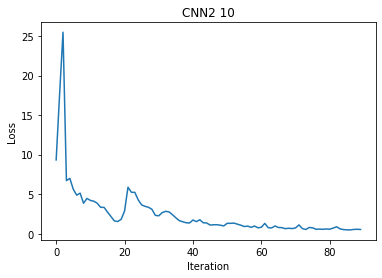

In [62]:
task = train_tasks["db3e9e38"]["train"]
model, num_steps, losses = solve_task(task)
print('model:\n', model)
print('num_steps', num_steps)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('CNN2 10')
print(f"Last loss: {losses[-1]:.5f}")
plt.plot(losses)

In [51]:
@torch.no_grad()
def predict(model, task):
    predictions = []
    for sample in task:
        x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
        pred = model(x, 100).argmax(1).squeeze().cpu().numpy()
        predictions.append(pred)
    return predictions

In [52]:
def evaluate(tasks):
    result = []
    predictions = []
    for idx, task in tqdm(tasks.items()):
        if input_output_shape_is_same(task):
            model,num_steps,losses = solve_task(task["train"])
            pred = predict(model, task["test"])
            score = calk_score(task["test"], pred)
        else:
            pred = [el["input"] for el in task["test"]]
            score = [0] * len(task["test"])

        predictions.append(pred)
        result.append(score)
        
    return result, predictions

In [53]:
train_result, train_predictions = evaluate(train_tasks)
train_solved = [any(score) for score in train_result]

total = sum([len(score) for score in train_result])
print(f"solved : {sum(train_solved)} from {total} ({sum(train_solved)/total})")





  0%|          | 0/400 [00:00<?, ?it/s]



  0%|          | 1/400 [00:05<37:58,  5.71s/it]



  1%|          | 4/400 [00:11<30:27,  4.61s/it]



  1%|▏         | 5/400 [00:30<58:42,  8.92s/it]



  2%|▏         | 7/400 [00:35<45:11,  6.90s/it]



  2%|▎         | 10/400 [00:39<34:16,  5.27s/it]



  3%|▎         | 11/400 [00:43<31:37,  4.88s/it]



  3%|▎         | 12/400 [00:50<34:52,  5.39s/it]



  3%|▎         | 13/400 [00:57<38:00,  5.89s/it]



  4%|▍         | 16/400 [01:02<29:50,  4.66s/it]



  4%|▍         | 17/400 [01:11<38:27,  6.03s/it]



  4%|▍         | 18/400 [01:17<37:15,  5.85s/it]



  5%|▍         | 19/400 [01:38<1:06:16, 10.44s/it]



  5%|▌         | 20/400 [01:46<1:02:02,  9.80s/it]



  6%|▌         | 23/400 [01:55<48:28,  7.72s/it]  



  6%|▌         | 24/400 [02:07<56:52,  9.08s/it]



  6%|▋         | 25/400 [02:15<54:53,  8.78s/it]



  7%|▋         | 27/400 [02:19<42:01,  6.76s/it]



  7%|▋         | 28/400 [02:24<38:49,  6.26s/it]



  7%|▋         

 48%|████▊     | 194/400 [18:18<21:55,  6.38s/it]



 49%|████▉     | 195/400 [18:25<21:51,  6.40s/it]



 49%|████▉     | 196/400 [18:34<24:39,  7.25s/it]



 49%|████▉     | 197/400 [18:40<23:47,  7.03s/it]



 50%|████▉     | 198/400 [18:46<22:26,  6.67s/it]



 50%|████▉     | 199/400 [19:04<33:03,  9.87s/it]



 50%|█████     | 200/400 [19:11<30:14,  9.07s/it]



 51%|█████     | 203/400 [19:19<23:31,  7.16s/it]



 51%|█████     | 204/400 [19:38<35:26, 10.85s/it]



 51%|█████▏    | 205/400 [20:01<46:34, 14.33s/it]



 52%|█████▏    | 206/400 [20:10<41:10, 12.73s/it]



 52%|█████▏    | 209/400 [20:17<30:39,  9.63s/it]



 53%|█████▎    | 213/400 [20:22<22:08,  7.10s/it]



 54%|█████▎    | 214/400 [20:34<26:53,  8.67s/it]



 54%|█████▍    | 215/400 [20:41<25:01,  8.11s/it]



 54%|█████▍    | 216/400 [20:49<24:38,  8.04s/it]



 54%|█████▍    | 217/400 [21:00<27:00,  8.85s/it]



 55%|█████▍    | 218/400 [21:12<29:44,  9.80s/it]



 55%|█████▌    | 221/400 [21:25<24:27,  8.20s/

 96%|█████████▌| 384/400 [38:29<02:18,  8.65s/it]



 97%|█████████▋| 387/400 [38:41<01:33,  7.23s/it]



 97%|█████████▋| 388/400 [38:59<02:03, 10.33s/it]



 98%|█████████▊| 390/400 [39:10<01:29,  8.91s/it]



 98%|█████████▊| 391/400 [39:18<01:18,  8.73s/it]



 98%|█████████▊| 393/400 [39:48<01:14, 10.61s/it]



 98%|█████████▊| 394/400 [39:56<00:57,  9.63s/it]



 99%|█████████▉| 395/400 [40:04<00:46,  9.23s/it]



100%|█████████▉| 399/400 [40:13<00:07,  7.12s/it]



100%|██████████| 400/400 [40:28<00:00,  6.07s/it]

solved : 6 from 416 (0.014423076923076924)






0it [00:00, ?it/s]

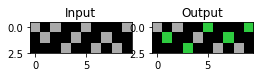

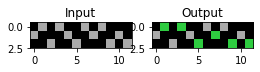

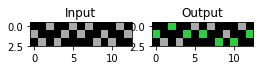

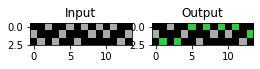

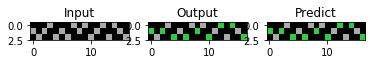





58it [00:03, 15.18it/s]

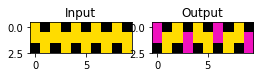

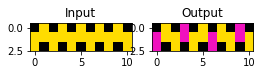

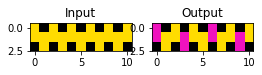

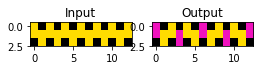

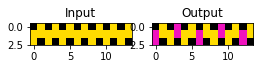

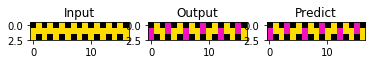





161it [00:05, 19.30it/s]

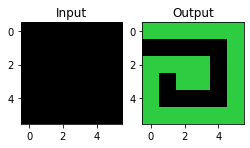

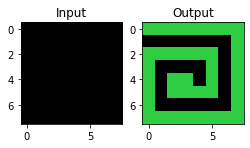

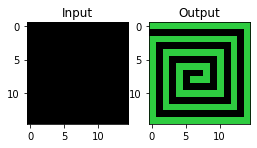

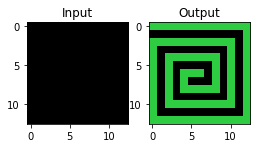

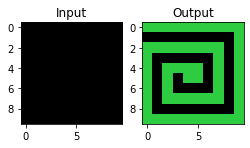

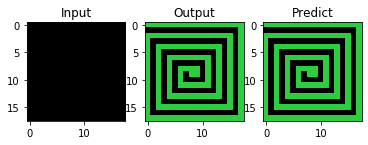





256it [00:07, 23.94it/s]

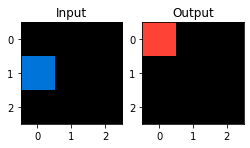

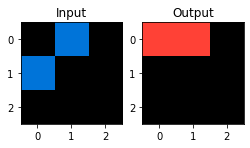

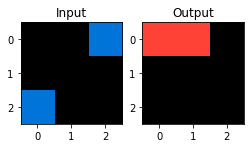

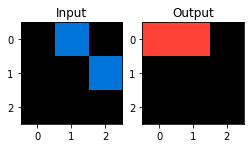

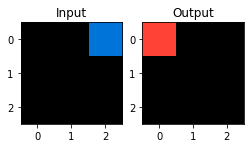

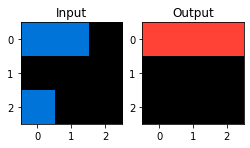

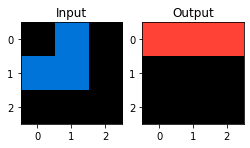

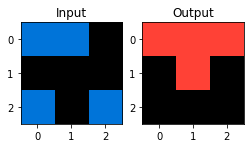

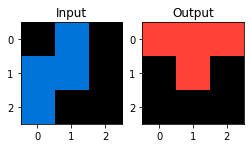

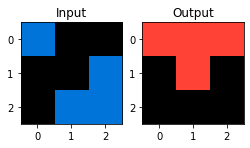

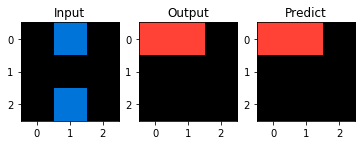

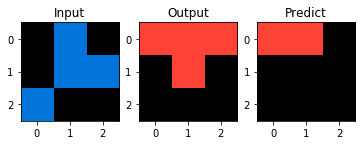





272it [00:10, 10.72it/s]

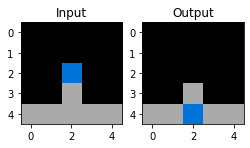

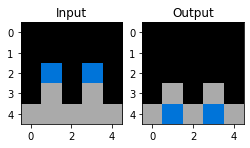

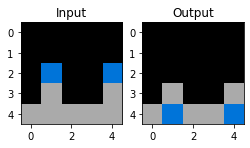

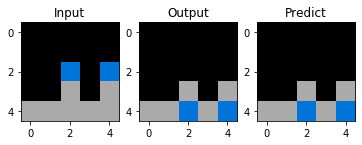





292it [00:12, 11.95it/s]

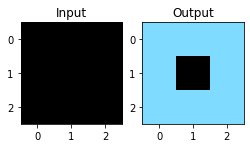

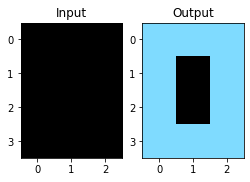

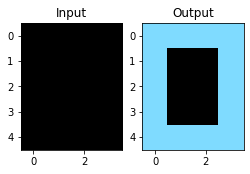

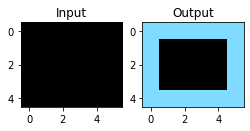

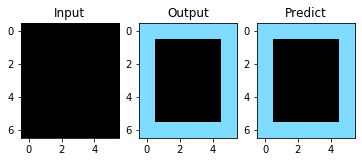





400it [00:13, 29.70it/s]


In [54]:
for task, prediction, solved in tqdm(zip(train_tasks.values(), train_predictions, train_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])

In [55]:
valid_result, valid_predictions = evaluate(valid_tasks)
valid_solved = [any(score) for score in valid_result]

total = sum([len(score) for score in valid_result])
print(f"solved : {sum(valid_solved)} from {total} ({sum(valid_solved)/total})")





  0%|          | 0/400 [00:00<?, ?it/s]



  0%|          | 2/400 [00:07<25:14,  3.81s/it]



  1%|          | 3/400 [00:30<1:02:52,  9.50s/it]



  1%|          | 4/400 [00:44<1:11:15, 10.80s/it]



  1%|▏         | 5/400 [00:57<1:16:09, 11.57s/it]



  2%|▏         | 7/400 [01:08<1:03:49,  9.74s/it]



  2%|▏         | 8/400 [01:25<1:16:55, 11.77s/it]



  2%|▏         | 9/400 [01:38<1:20:25, 12.34s/it]



  2%|▎         | 10/400 [01:48<1:15:14, 11.58s/it]



  3%|▎         | 11/400 [02:05<1:25:25, 13.18s/it]



  3%|▎         | 12/400 [02:26<1:39:37, 15.41s/it]



  3%|▎         | 13/400 [03:04<2:24:36, 22.42s/it]



  4%|▎         | 14/400 [03:11<1:54:45, 17.84s/it]



  4%|▍         | 16/400 [03:23<1:31:03, 14.23s/it]



  4%|▍         | 17/400 [03:32<1:21:31, 12.77s/it]



  5%|▍         | 19/400 [03:53<1:16:40, 12.08s/it]



  6%|▌         | 22/400 [04:00<57:24,  9.11s/it]  



  6%|▌         | 23/400 [04:25<1:28:01, 14.01s/it]



  6%|▌         | 24/400 [04:33<1:15:23, 12.0

 44%|████▍     | 176/400 [27:03<30:11,  8.09s/it]



 44%|████▍     | 177/400 [27:12<31:44,  8.54s/it]



 44%|████▍     | 178/400 [27:17<27:18,  7.38s/it]



 45%|████▌     | 180/400 [27:25<23:19,  6.36s/it]



 46%|████▋     | 185/400 [27:37<18:29,  5.16s/it]



 46%|████▋     | 186/400 [27:51<28:04,  7.87s/it]



 47%|████▋     | 187/400 [28:04<33:27,  9.42s/it]



 48%|████▊     | 190/400 [28:17<27:32,  7.87s/it]



 48%|████▊     | 193/400 [28:33<24:30,  7.11s/it]



 48%|████▊     | 194/400 [28:43<27:38,  8.05s/it]



 49%|████▉     | 195/400 [29:04<40:21, 11.81s/it]



 49%|████▉     | 196/400 [29:12<36:48, 10.83s/it]



 49%|████▉     | 197/400 [29:20<33:48,  9.99s/it]



 50%|████▉     | 198/400 [29:26<29:31,  8.77s/it]



 50%|█████     | 200/400 [29:31<23:05,  6.93s/it]



 50%|█████     | 202/400 [29:51<25:31,  7.74s/it]



 51%|█████     | 203/400 [30:06<32:36,  9.93s/it]



 51%|█████     | 204/400 [30:20<36:48, 11.27s/it]



 52%|█████▏    | 206/400 [30:33<31:31,  9.75s/

 92%|█████████▏| 368/400 [54:42<03:33,  6.67s/it]



 92%|█████████▏| 369/400 [54:51<03:44,  7.25s/it]



 92%|█████████▎| 370/400 [55:08<05:06, 10.22s/it]



 93%|█████████▎| 371/400 [55:14<04:22,  9.06s/it]



 93%|█████████▎| 372/400 [55:30<05:09, 11.04s/it]



 94%|█████████▎| 374/400 [55:48<04:32, 10.47s/it]



 94%|█████████▍| 375/400 [56:05<05:08, 12.33s/it]



 94%|█████████▍| 376/400 [56:14<04:38, 11.59s/it]



 94%|█████████▍| 377/400 [56:26<04:26, 11.59s/it]



 95%|█████████▍| 379/400 [56:38<03:26,  9.85s/it]



 96%|█████████▌| 382/400 [56:51<02:27,  8.19s/it]



 96%|█████████▌| 384/400 [57:16<02:33,  9.60s/it]



 96%|█████████▋| 385/400 [57:24<02:14,  8.95s/it]



 96%|█████████▋| 386/400 [57:35<02:16,  9.72s/it]



 97%|█████████▋| 388/400 [57:42<01:34,  7.85s/it]



 97%|█████████▋| 389/400 [57:54<01:39,  9.08s/it]



 98%|█████████▊| 391/400 [58:02<01:07,  7.49s/it]



 98%|█████████▊| 392/400 [58:13<01:08,  8.59s/it]



 99%|█████████▉| 395/400 [58:28<00:37,  7.55s/

solved : 1 from 419 (0.002386634844868735)






0it [00:00, ?it/s]

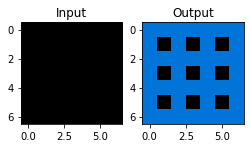

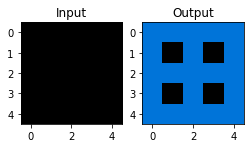

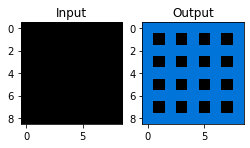

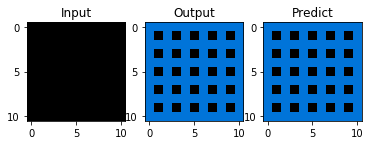





400it [00:01, 273.33it/s]


In [56]:
for task, prediction, solved in tqdm(zip(valid_tasks.values(), valid_predictions, valid_solved)):
    if solved:
        for i in range(len(task['train'])):
            plot_sample(task['train'][i])
            
        for i in range(len(task['test'])):
            plot_sample(task['test'][i], prediction[i])